# Decision Trees

Here we'll explore a class of algorithms based on decision trees.
Decision trees at their root are extremely intuitive.  They
encode a series of "if" and "else" choices, similar to how a person might make a decision.
However, which questions to ask, and how to proceed for each answer is entirely learned from the data.

For example, if you wanted to create a guide to identifying an animal found in nature, you
might ask the following series of questions:

- Is the animal bigger or smaller than a meter long?
    + *bigger*: does the animal have horns?
        - *yes*: are the horns longer than ten centimeters?
        - *no*: is the animal wearing a collar
    + *smaller*: does the animal have two or four legs?
        - *two*: does the animal have wings?
        - *four*: does the animal have a bushy tail?

and so on.  This binary splitting of questions is the essence of a decision tree.

One of the main benefit of tree-based models is that they require little preprocessing of the data.
They can work with variables of different types (continuous and discrete) and are invariant to scaling of the features.

Another benefit is that tree-based models are what is called "nonparametric", which means they don't have a fix set of parameters to learn. Instead, a tree model can become more and more flexible, if given more data.
In other words, the number of free parameters grows with the number of samples and is not fixed, as for example in linear models.


In [167]:
# temporary fix to avoid spurious warning raised in scikit-learn 1.0.0
# it will be solved in scikit-learn 1.0.1
import warnings
warnings.filterwarnings("ignore", message="X has feature names.*")
warnings.filterwarnings("ignore", message="X does not have valid feature names.*")

## Decision Tree Classification

### Generate a simple dataset

In [168]:
import pandas as pd
from sklearn.datasets import make_blobs

X, y = make_blobs(
    centers=[[0, 0], [1, 1]], random_state=61526, n_samples=100
)
X = pd.DataFrame(X, columns=["Feature #0", "Feature #1"])
class_names = np.array(["class #0", "class #1"])
y = pd.Series(class_names[y], name="Classes").astype("category")
data = pd.concat([X, y], axis=1)

First, let's look at the generated data

In [169]:
import numpy as np
classes = np.unique(y)
print(f"The class labels are: {classes}")

The class labels are: ['class #0' 'class #1']


In [170]:
import seaborn as sns
sns.set_context("poster")

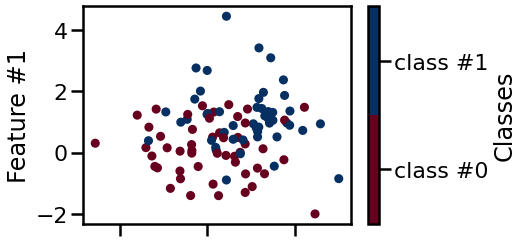

In [171]:
import matplotlib.pyplot as plt

_ = data.plot.scatter(
    x="Feature #0",
    y="Feature #1",
    c="Classes",
    s=50,
    cmap=plt.cm.RdBu,
)

We will create a function to create this scatter plot by passing 2 variables: `data` and `labels`.

### Train a decision tree classifier

We can learn a set of binary rule using a portion of the data. Using the rules learned, we will predict on the testing data.

In [172]:
from sklearn.model_selection import train_test_split

data_train, data_test, X_train, X_test, y_train, y_test = train_test_split(
    data, X, y, random_state=42
)

In [173]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=1)
tree.fit(X_train, y_train)
pred = tree.predict(X_test)
pred

array(['class #1', 'class #1', 'class #1', 'class #0', 'class #0',
       'class #1', 'class #0', 'class #1', 'class #1', 'class #1',
       'class #0', 'class #1', 'class #0', 'class #0', 'class #1',
       'class #1', 'class #1', 'class #1', 'class #1', 'class #1',
       'class #1', 'class #0', 'class #0', 'class #1', 'class #1'],
      dtype=object)

We can plot the decision boundaries found using the training data.

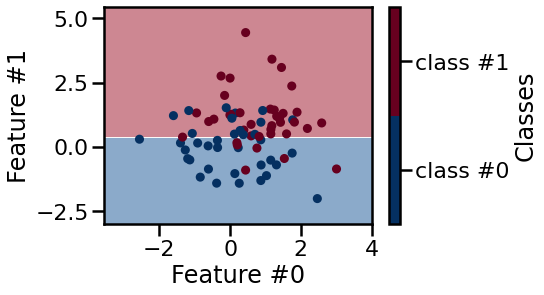

In [174]:
from helper.plotting import DecisionBoundaryDisplay

display = DecisionBoundaryDisplay.from_estimator(
    tree, X_train, cmap=plt.cm.RdBu_r, alpha=0.5
)
_ = data_train.plot.scatter(
    x="Feature #0",
    y="Feature #1",
    c="Classes",
    s=50,
    cmap=plt.cm.RdBu_r,
    ax=display.ax_
)

Similarly, we get the following classification on the testing set.

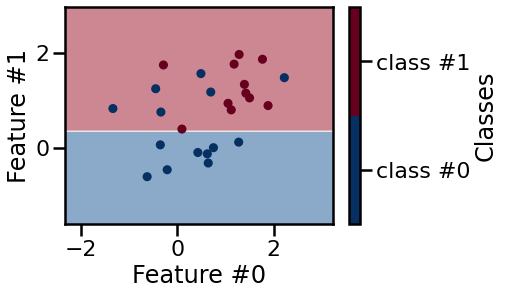

In [175]:
display = DecisionBoundaryDisplay.from_estimator(
    tree, X_test, cmap=plt.cm.RdBu_r, alpha=0.5
)
_ = data_test.plot.scatter(
    x="Feature #0",
    y="Feature #1",
    c="Classes",
    s=50,
    cmap=plt.cm.RdBu_r,
    ax=display.ax_
)

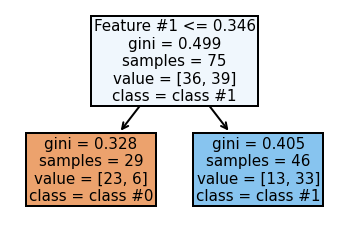

In [176]:
from sklearn.tree import plot_tree

_ = plot_tree(
    tree, feature_names=X.columns, class_names=class_names, filled=True
)

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
     <li> Modify the depth of the tree and see how the partitioning evolves. </li>
     <li>What can you say about under- and over-fitting of the tree model?</li>
     <li>How would you choose the best depth?</li>
     </ul>
</div>

In [177]:
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

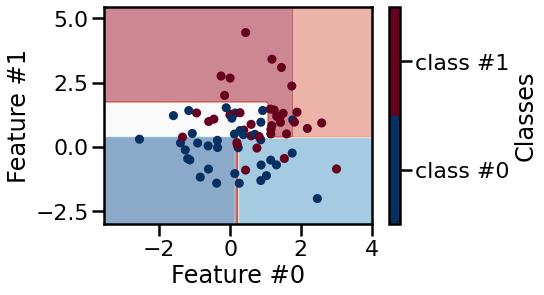

In [178]:
display = DecisionBoundaryDisplay.from_estimator(
    tree, X_train, cmap=plt.cm.RdBu_r, alpha=0.5,
)
_ = data_train.plot.scatter(
    x="Feature #0",
    y="Feature #1",
    c="Classes",
    s=50,
    cmap=plt.cm.RdBu_r,
    ax=display.ax_
)

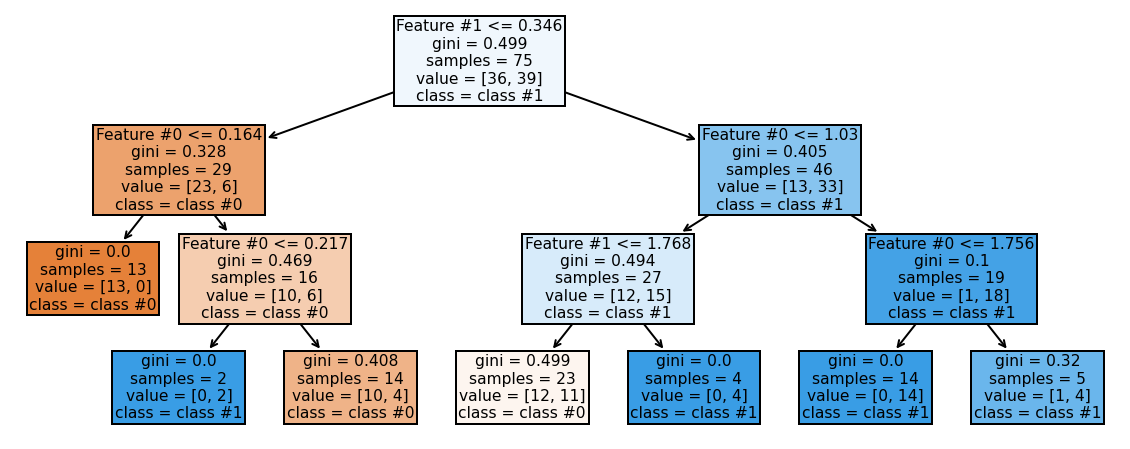

In [179]:
_, ax = plt.subplots(figsize=(20, 8))
_ = plot_tree(
    tree, feature_names=X.columns, class_names=class_names, filled=True, ax=ax
)

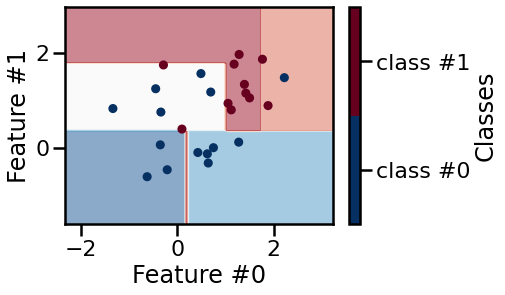

In [180]:
display = DecisionBoundaryDisplay.from_estimator(
    tree, X_test, cmap=plt.cm.RdBu_r, alpha=0.5
)
_ = data_test.plot.scatter(
    x="Feature #0",
    y="Feature #1",
    c="Classes",
    s=50,
    cmap=plt.cm.RdBu_r,
    ax=display.ax_
)

There are many parameter that control the complexity of a tree, but the one that might be easiest to understand is the maximum depth. This limits how finely the tree can partition the input space, or how many "if-else" questions can be asked before deciding which class a sample lies in.

This parameter is important to tune for trees and tree-based models. The interactive plot below shows how underfit and overfit looks like for this model. Having a ``max_depth`` of 1 is clearly an underfit model, while a depth of 7 or 8 clearly overfits. The maximum depth a tree can be grown at for this dataset is 8, at which point each leave only contains samples from a single class. This is known as all leaves being "pure."

In the interactive plot below, the regions are assigned blue and red colors to indicate the predicted class for that region. The shade of the color indicates the predicted probability for that class (darker = higher probability), while yellow regions indicate an equal predicted probability for either class.

### Aside note regarding the partitioning in decision tree

In this section, we will go slightly more into details regading how a tree is selecting the best partition. First, instead of using synthetic data, we will use a real dataset this time.

In [181]:
dataset = pd.read_csv("../datasets/penguins.csv")
dataset = dataset.dropna(subset=["Body Mass (g)"])
dataset.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,2007-11-11,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,2007-11-11,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,2007-11-16,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,2007-11-16,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN
5,PAL0708,6,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A2,Yes,2007-11-16,39.3,20.6,190.0,3650.0,MALE,8.66496,-25.29805,NaN


We will build a decision tree to classify the penguin species using their body mass as a feature. To simplify the problem will focus only the Adelie and Gentoo species.

In [182]:
# Only select the column of interest
dataset = dataset[["Body Mass (g)", "Species"]]
# Make the species name more readable
dataset["Species"] = dataset["Species"].apply(lambda x: x.split()[0])
# Only select the Adelie and Gentoo penguins
dataset = dataset.set_index("Species").loc[["Adelie", "Gentoo"], :]
# Sort all penguins by their body mass
dataset = dataset.sort_values(by="Body Mass (g)")
# Convert the dataframe (2D) to a series (1D)
dataset = dataset.squeeze()
dataset

Species
Adelie    2850.0
Adelie    2850.0
Adelie    2900.0
Adelie    2900.0
Adelie    2900.0
           ...  
Gentoo    5950.0
Gentoo    6000.0
Gentoo    6000.0
Gentoo    6050.0
Gentoo    6300.0
Name: Body Mass (g), Length: 274, dtype: float64

We will first look at the body mass distribution for each specie.

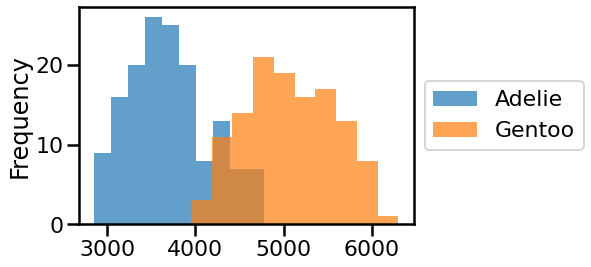

In [183]:
_, ax = plt.subplots()
dataset.groupby("Species").plot.hist(ax=ax, alpha=0.7, legend=True)
ax.set_ylabel("Frequency")
_ = ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

Instead to look at the distribution, we can look at all samples directly.

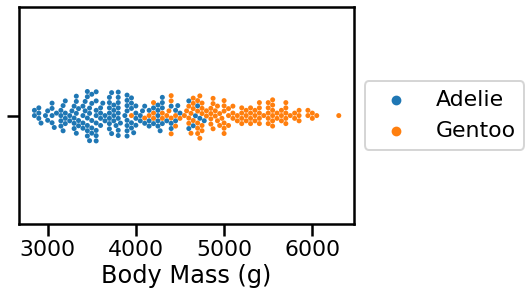

In [184]:
ax = sns.swarmplot(x=dataset.values, y=[""] * len(dataset), hue=dataset.index)
ax.set_xlabel(dataset.name)
_ = ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

When we build a tree, we want to find splits, one at the time, such that we partition the data in way that classes as "unmixed" as possible. Let's make a first completely random split to highlight the principle.

In [185]:
# create a random state such we all have the same results
rng = np.random.RandomState(42)

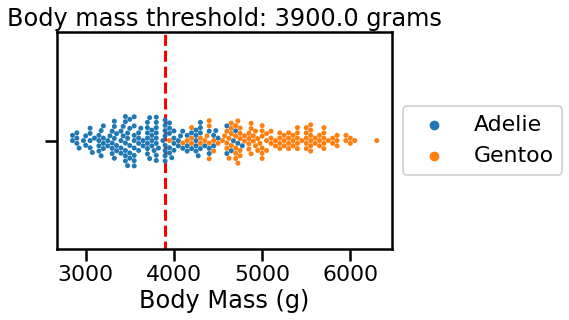

In [186]:
random_idx = rng.choice(dataset.size)

ax = sns.swarmplot(x=dataset.values, y=[""] * len(dataset), hue=dataset.index)
ax.set_xlabel(dataset.name)
ax.set_title(f"Body mass threshold: {dataset[random_idx]} grams")
ax.vlines(dataset[random_idx], -1, 1, color="red", linestyle="--")
_ = ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

Once the split done, we seek for having two partitions for which the samples are as much as possible from a single class and contains as many samples as possible. In decision tree, we used a **criterion** to assess the quality of a split. The **entropy** is one of the statistic which can describe the class mixity in a partition. Let's compute the entropy for the full dataset, the set on the left of the threshold and the set on the right of the split.

In [187]:
from scipy.stats import entropy

In [188]:
dataset.index.value_counts()

Adelie    151
Gentoo    123
Name: Species, dtype: int64

In [189]:
parent_entropy = entropy(
    dataset.index.value_counts(normalize=True)
)
parent_entropy

0.6879166791258041

In [190]:
left_entropy = entropy(
    dataset[:random_idx].index.value_counts(normalize=True)
)
left_entropy

0.0

In [191]:
right_entropy = entropy(
    dataset[random_idx:].index.value_counts(normalize=True)
)
right_entropy

0.5975068586842202

We can see the quality of the split by combining the entropies. This is known as the **information gain**.

In [192]:
parent_entropy - (left_entropy + right_entropy)

0.09040982044158397

However, we should normalize the entropies with the number of samples in each sets.

In [193]:
def information_gain(labels_parent, labels_left, labels_right):
    # compute the entropies
    entropy_parent = entropy(labels_parent.value_counts(normalize=True))
    entropy_left = entropy(labels_left.value_counts(normalize=True))
    entropy_right = entropy(labels_right.value_counts(normalize=True))

    n_samples_parent = labels_parent.size
    n_samples_left = labels_left.size
    n_samples_right = labels_right.size

    # normalize with the number of samples
    normalized_entropy_left = ((n_samples_left / n_samples_parent) * 
                               entropy_left)
    normalized_entropy_right = ((n_samples_right / n_samples_parent) *
                                entropy_right)

    return (entropy_parent -
            normalized_entropy_left - normalized_entropy_right)

In [194]:
information_gain(
    dataset.index,
    dataset[:random_idx].index,
    dataset[random_idx:].index
)

0.3128393809736659

So, we can compute the information gain for all possible body mass thresholds.

In [195]:
all_information_gain = pd.Series(
    [information_gain(dataset.index, dataset[:idx].index, dataset[idx:].index)
     for idx in range(dataset.size)],
    index=dataset,
)

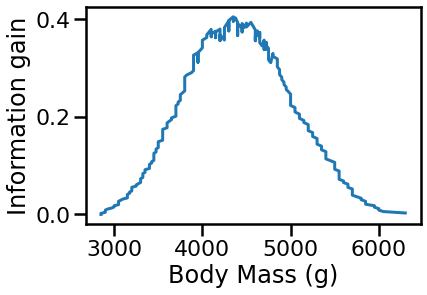

In [196]:
ax = all_information_gain.plot()
_ = ax.set_ylabel("Information gain")

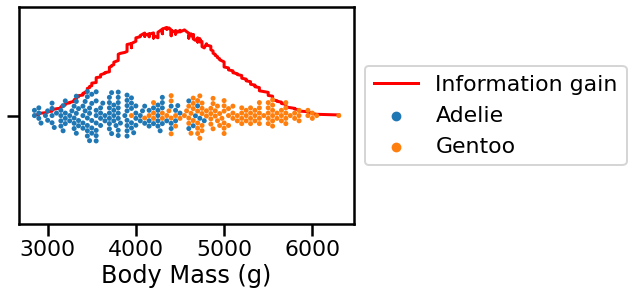

In [197]:
ax = (all_information_gain * -1).plot(color="red", label="Information gain")
ax = sns.swarmplot(x=dataset.values, y=[""] * len(dataset), hue=dataset.index)
_ = ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

We can see that the maximum of the information gain corresponds to the split which best partition our data. So we can check the corresponding body mass threshold.

In [198]:
all_information_gain.idxmax()

4350.0

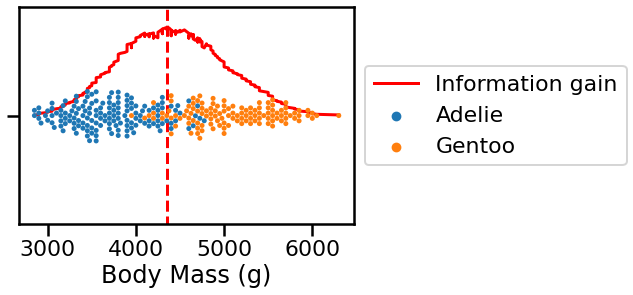

In [199]:
ax = (all_information_gain * -1).plot(color="red", label="Information gain")
ax = sns.swarmplot(x=dataset.values, y=[""] * len(dataset), hue=dataset.index)
ax.vlines(
    all_information_gain.idxmax(), -1, 1,
    color="red", linestyle="--"
)
_ = ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

## Decision Tree Regression

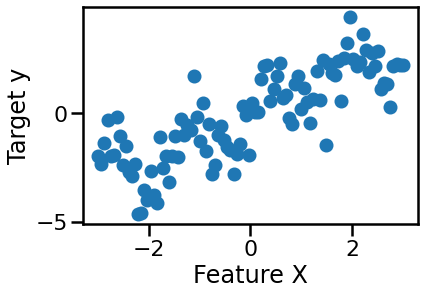

In [200]:
rnd = np.random.RandomState(42)
x = np.linspace(-3, 3, 100)
y_no_noise = np.sin(4 * x) + x
y = y_no_noise + rnd.normal(size=len(x))
X = x.reshape(-1, 1)

plt.figure()
plt.xlabel('Feature X')
plt.ylabel('Target y')
_ = plt.scatter(X, y)

In [201]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(max_depth=2)
reg.fit(X, y)

DecisionTreeRegressor(max_depth=2)

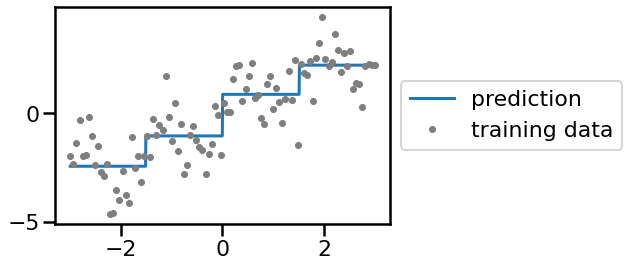

In [202]:
X_test = np.linspace(-3, 3, 1000).reshape((-1, 1))
y_test = reg.predict(X_test)

plt.figure()
plt.plot(X_test.ravel(), y_test, color='tab:blue', label="prediction")
plt.plot(X.ravel(), y, 'C7.', label="training data")
_ = plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

A single decision tree allows us to estimate the signal in a non-parametric way,
but clearly has some issues.  In some regions, the model shows high bias and
under-fits the data.
(seen in the long flat lines which don't follow the contours of the data),
while in other regions the model shows high variance and over-fits the data
(reflected in the narrow spikes which are influenced by noise in single points).

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>
      Take the above example and repeat the training/testing by changing depth of the tree.
      </li>
      <li>
      What can you conclude?
      </li>
    </ul>
</div>

## Other tree hyperparameters

In [203]:
from sklearn.datasets import make_blobs

feature_names = ["Feature #0", "Feature #1"]
target_name = "Class"

# Blobs that will be interlaced
X_1, y_1 = make_blobs(
    n_samples=300, centers=[[0, 0], [-1, -1]], random_state=0
)
# Blobs that will be easily separated
X_2, y_2 = make_blobs(
    n_samples=300, centers=[[3, 6], [7, 0]], random_state=0
)

X = np.concatenate([X_1, X_2], axis=0)
y = np.concatenate([y_1, y_2])
data = np.concatenate([X, y[:, np.newaxis]], axis=1)
data = pd.DataFrame(
    data, columns=feature_names + [target_name])
data[target_name] = data[target_name].astype(np.int64).astype("category")
data

,Feature #0,Feature #1,Class
0,0.950088,-0.151357,0
1,1.955912,0.390093,0
2,-1.353432,-2.616474,1
3,-0.455533,0.017479,0
4,0.465662,-1.536244,0
...,...,...,...
595,7.453782,-1.829740,1
596,2.260437,7.543015,0
597,4.099660,6.655264,0
598,7.284280,1.742669,1


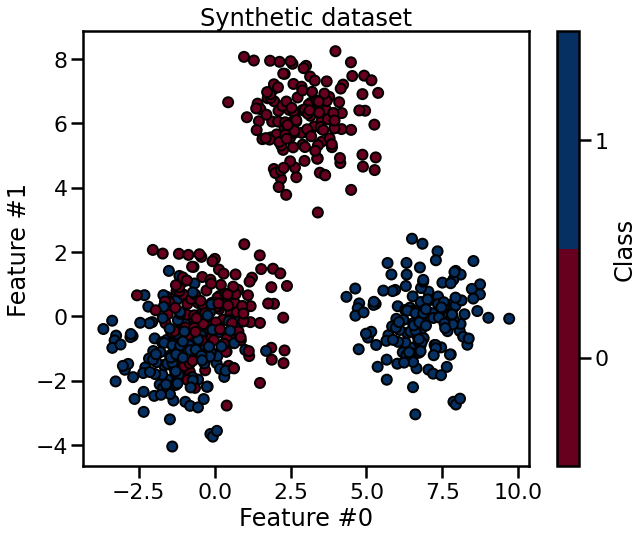

In [204]:
_, ax = plt.subplots(figsize=(10, 8))
data.plot.scatter(
    x="Feature #0",
    y="Feature #1",
    c="Class",
    s=100,
    cmap=plt.cm.RdBu,
    edgecolor="k",
    ax=ax,
)
_ = plt.title("Synthetic dataset")

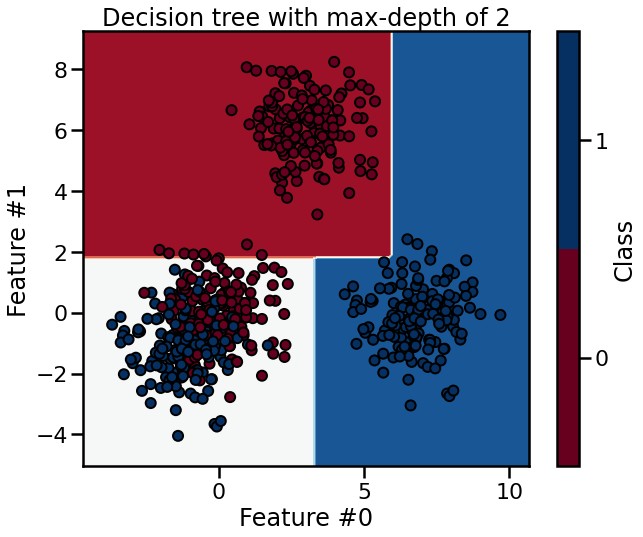

In [205]:
max_depth = 2
tree = DecisionTreeClassifier(max_depth=max_depth)
tree.fit(X, y)

_, ax = plt.subplots(figsize=(10, 8))
DecisionBoundaryDisplay.from_estimator(tree, X, cmap=plt.cm.RdBu, ax=ax)
data.plot.scatter(
    x="Feature #0",
    y="Feature #1",
    c="Class",
    s=100,
    cmap=plt.cm.RdBu,
    edgecolor="k",
    ax=ax,
)
_ = plt.title(f"Decision tree with max-depth of {max_depth}")

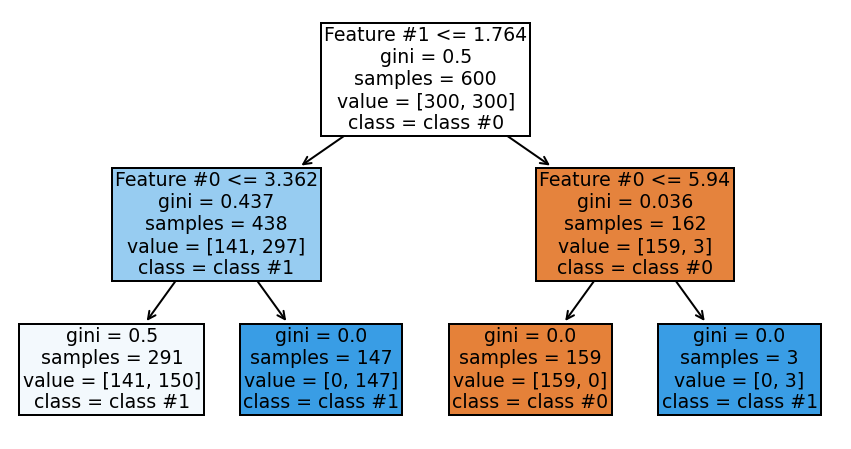

In [144]:
_, ax = plt.subplots(figsize=(15, 8))
_ = plot_tree(
    tree, feature_names=feature_names, class_names=class_names, filled=True, ax=ax
)

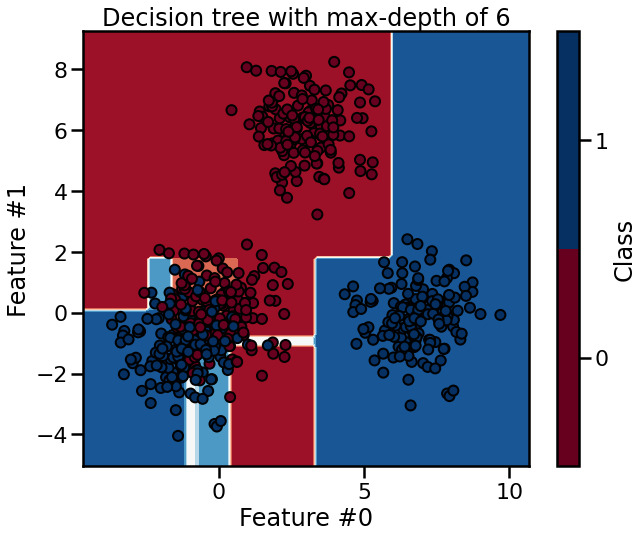

In [154]:
max_depth = 6
tree = DecisionTreeClassifier(max_depth=max_depth)
tree.fit(X, y)

_, ax = plt.subplots(figsize=(10, 8))
DecisionBoundaryDisplay.from_estimator(tree, X, cmap=plt.cm.RdBu, ax=ax)
data.plot.scatter(
    x="Feature #0",
    y="Feature #1",
    c="Class",
    s=100,
    cmap=plt.cm.RdBu,
    edgecolor="k",
    ax=ax,
)
_ = plt.title(f"Decision tree with max-depth of {max_depth}")

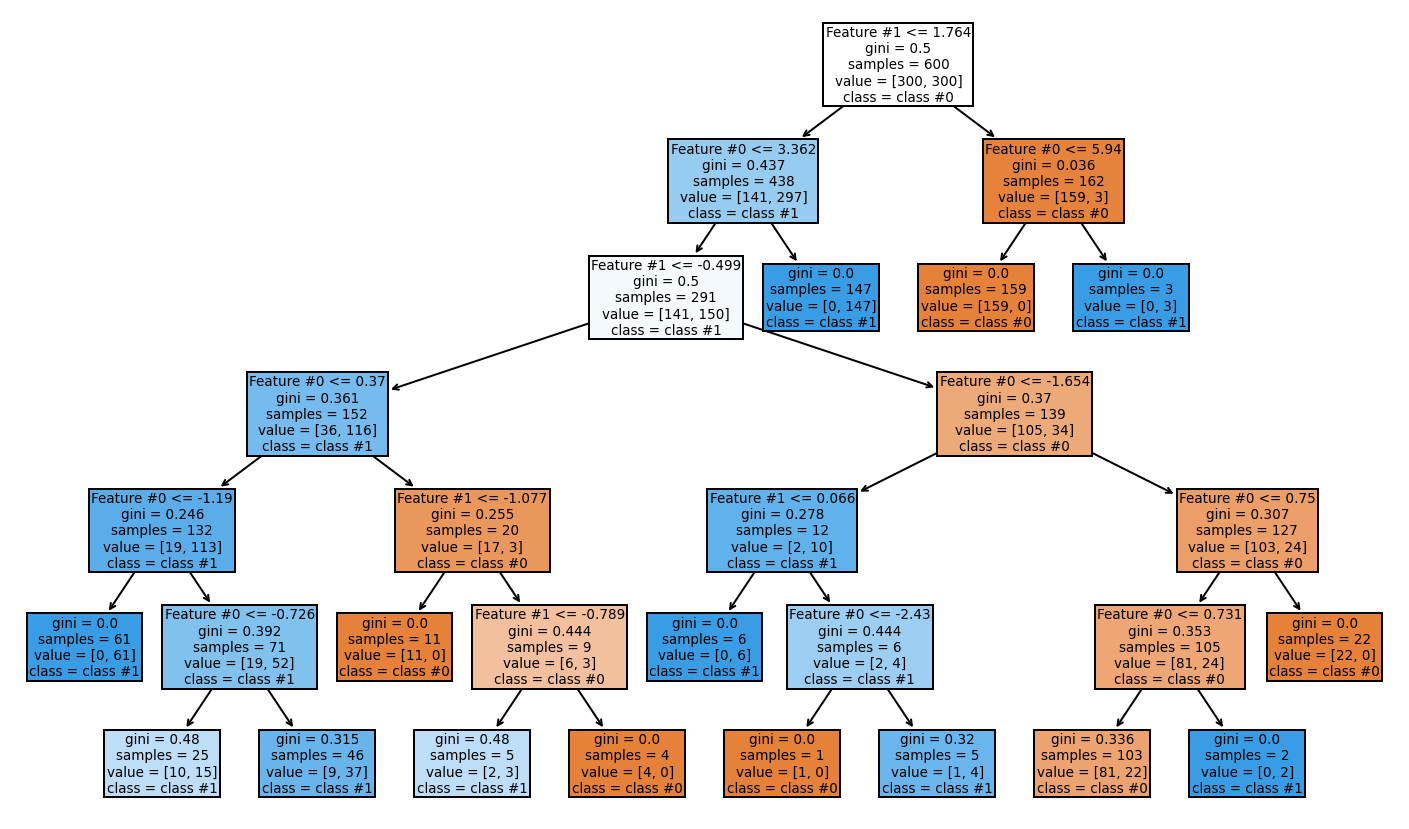

In [156]:
_, ax = plt.subplots(figsize=(25, 15))
_ = plot_tree(
    tree, feature_names=feature_names, class_names=class_names, filled=True, ax=ax
)

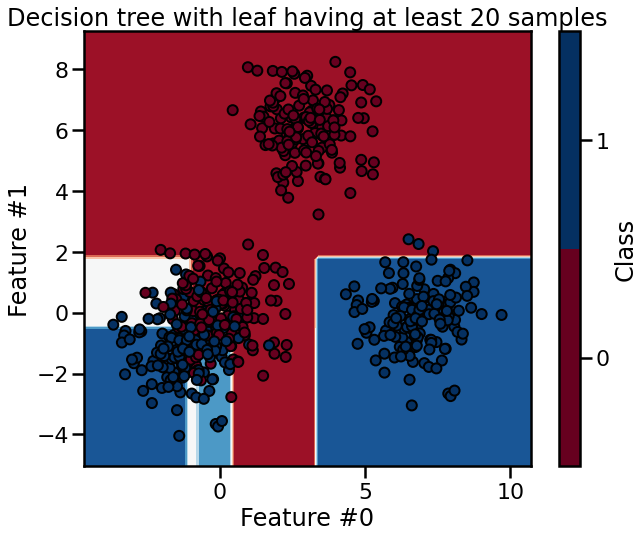

In [157]:
min_samples_leaf = 20
tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
tree.fit(X, y)

_, ax = plt.subplots(figsize=(10, 8))
DecisionBoundaryDisplay.from_estimator(tree, X, cmap=plt.cm.RdBu, ax=ax)
data.plot.scatter(
    x="Feature #0",
    y="Feature #1",
    c="Class",
    s=100,
    cmap=plt.cm.RdBu,
    edgecolor="k",
    ax=ax,
)
_ = plt.title(
    f"Decision tree with leaf having at least {min_samples_leaf} samples")

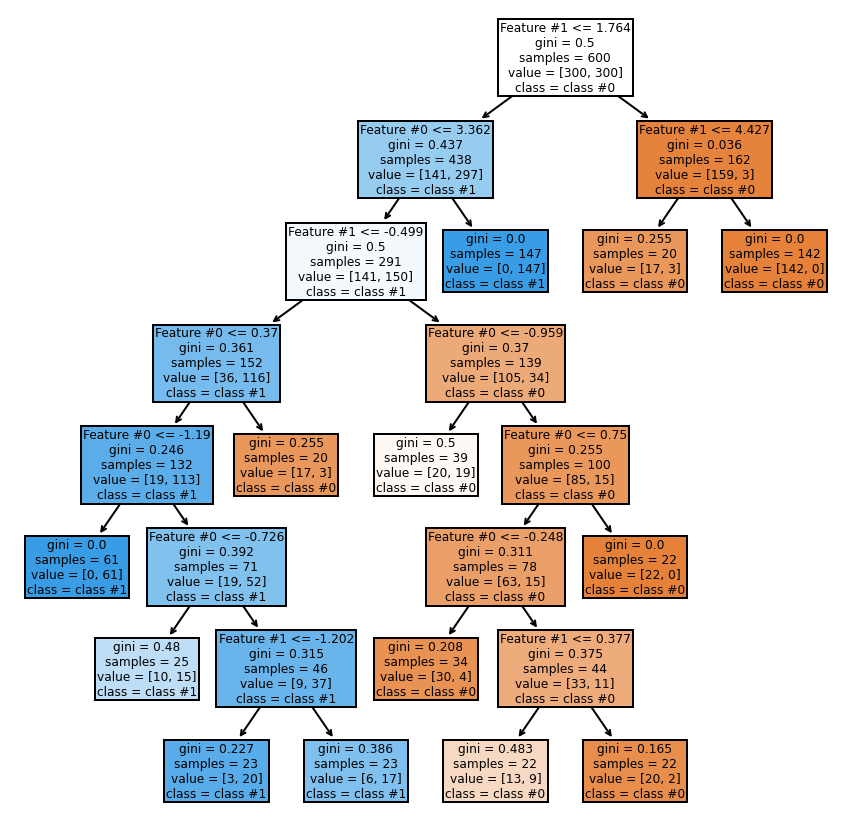

In [158]:
_, ax = plt.subplots(figsize=(15, 15))
_ = plot_tree(
    tree, feature_names=feature_names, class_names=class_names, filled=True, ax=ax
)